In [1]:
import os
import numpy as np
import tensorflow as tf
from PIL import Image, ImageDraw, ImageFont
from random import randrange
from IPython.display import display

In [2]:
WIDTH       =   200
HEIGHT      =   100
MINX        =    20
MINY        =    20
MAXX        =    WIDTH-60
MAXY        =    HEIGHT-60
MINSIZE     =    24
MAXSIZE     =    48
NUMCHARS    =     4 # 4 character CAPTCHA
SYMBOL_SIZE =    50
SYMBOL_SET  =    "0123456789"
NUM_SYMBOLS = len(SYMBOL_SET)

In [3]:
def generate_captcha(return_image=False):
    fonts = [i for i in os.listdir("../fonts") if i.endswith('.ttf')]
    while True:
        x_pos = 0
        answer = ''
        boxes = []
        img = Image.new('RGB', (WIDTH, HEIGHT), color = (255,255,255))
        canvas = ImageDraw.Draw(img)
        for i in range(NUMCHARS):
            font = ImageFont.truetype(f'../fonts/{fonts[randrange(len(fonts))]}', randrange(MINSIZE,MAXSIZE))
            character = SYMBOL_SET[randrange(NUM_SYMBOLS)]
            answer += character
            x_pos += randrange(10, MINX)
            y_pos = randrange(MINY, MAXY)
            position = (x_pos, y_pos)
            coords = canvas.textbbox(position, character, font)
            canvas.text(position, character, font=font, fill=(0,0,0), anchor="la")
            boxes.append(coords)
            x_pos = coords[2]
        x = np.array(list(img.tobytes())).reshape(WIDTH, HEIGHT, 3).astype(np.float64)/255.0
        
        if return_image:
            yield x, np.array(boxes).flatten(), img, answer
        else:
            yield x, np.array(boxes).flatten()

In [4]:
def draw_boxes(image, truth, pred=None):
    canvas = ImageDraw.Draw(image)
    truth = np.reshape(truth, (4,4))
    if pred is not None:
        pred = np.reshape(pred, (4,4))
    for i in range(len(truth)):
        canvas.rectangle(list(truth[i]), outline=(0, 255, 0), width=1)
        if pred is not None:
            canvas.rectangle(list(pred[i]), outline=(255 ,0 ,0), width=1)
    display(image)

(200, 100, 3)
Bounding Boxes: [ 11  43  29  65  44  49  66  76  78  44 103  75 122  45 147  76] (16,)


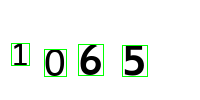

In [5]:
(x, y, image, answer) = next(generate_captcha(return_image=True))
print(x.shape)
print("Bounding Boxes:", y, y.shape)
draw_boxes(image, y)

In [6]:
box_model = tf.keras.models.load_model("../models/BBox_Regressor-100epochs.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step
Truth: [ 13  44  51  71  67  38  85  65  97  39 107  58 123  42 132  59]
Predicted: [ 16.160297  41.048     44.86048   70.61816   59.843533  39.174835
  78.14416   64.55072   92.24501   36.788647 106.907486  60.382404
 120.8978    38.19421  137.5872    62.21663 ]


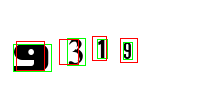

In [7]:
(x, y, image, answer) = next(generate_captcha(return_image=True))
y_pred = box_model.predict(x.reshape(-1, WIDTH, HEIGHT, 3))[0]
print("Truth:", y)
print("Predicted:", y_pred)
draw_boxes(image, y, y_pred)

In [8]:
test_size = 1000

In [9]:
mae_total = 0
for _ in range(test_size):
    x, y_true, image, answer = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(1, WIDTH, HEIGHT, 3), verbose=False)[0]
    mae_total += np.mean(np.abs(y_true - y_pred))
mae = mae_total / test_size
print(f"MAE per coordinate: {mae:.2f} pixels")

MAE per coordinate: 2.83 pixels


In [10]:
def compute_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# Then in your loop
iou_scores = []
for _ in range(test_size):
    x, y_true, image, answer = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(1, WIDTH, HEIGHT, 3), verbose=False)[0]
    for i in range(NUMCHARS):
        b1 = y_true[4*i:4*(i+1)]
        b2 = y_pred[4*i:4*(i+1)]
        iou_scores.append(compute_iou(b1, b2))
print(f"Average IoU: {np.mean(iou_scores):.2f}")

Average IoU: 0.61


In [11]:
error_margin = 5
count = 0

for i in range(test_size):
    x, y_true, image, answer = next(generate_captcha(return_image=True))
    y_pred = box_model.predict(x.reshape(-1, WIDTH, HEIGHT, 3), verbose=False)[0]
    count += np.sum(np.abs(y_true - y_pred) > error_margin)

print("Accuracy of", (test_size-count/16)*100/test_size, "% with error margin of", error_margin, "pixels")

Accuracy of 85.9375 % with error margin of 5 pixels


In [12]:
sym_model = tf.keras.models.load_model("../models/Symbol_Recognizer-100epochs.keras")

In [13]:
def captcha_solver(image):
    x = np.asarray(image).astype(np.float32) / 255.0
    boxes = box_model.predict(x.reshape(1, WIDTH, HEIGHT, 3), verbose=False)[0]
    sub_images = []
    for i in range(NUMCHARS):
        box = boxes[4*i:4*(i+1)]
        sub_img = image.crop(box).resize((SYMBOL_SIZE, SYMBOL_SIZE))
        tensor = np.asarray(sub_img).astype(np.float32) / 255.0
        sub_images.append(tensor.reshape(SYMBOL_SIZE, SYMBOL_SIZE, 3))
    batch = np.stack(sub_images)
    preds = sym_model.predict(batch, verbose=False)
    return ''.join(str(np.argmax(p)) for p in preds)

count = 0
for i in range(test_size):
    x, y, image, answer = next(generate_captcha(return_image=True))
    solve = captcha_solver(image)
    if answer != solve:
        count += 1

print("Accuracy:", (test_size-count)*100/test_size)

Accuracy: 72.3
